<a href="https://colab.research.google.com/github/pdebnam/Regression_Modeling_Real_Estate_Prices/blob/main/Real_Estate_Regression_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Real Estate Regression Project

$\textbf{Problem}:$ Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

$\textbf{Goal}:$ Using a dataset of real estate transactions, develop a model(s) to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters

Citation: The data used in this exercise originates from the following study:

Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.

It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science).

In [51]:
# Import all modules needed for this project
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the training dataset
data = pd.read_csv('real_estate.csv')
data.head()

,No,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


The data consists of the following variables:

$\textbf{transaction_date}$ - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)

$\textbf{house_age}$  - the house age (in years)

$\textbf{transit_distance}$  - the distance to the nearest light rail station (in meters)

$\textbf{local_convenience_stores}$  - the number of convenience stores within walking distance

$\textbf{latitude}$  - the geographic coordinate, latitude

$\textbf{longitude}$  - the geographic coordinate, longitude

$\textbf{price_per_unit}$ -  house price of unit area (3.3 square meters)

## Data Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        414 non-null    int64  
 1   transaction_date          414 non-null    float64
 2   house_age                 414 non-null    float64
 3   transit_distance          414 non-null    float64
 4   local_convenience_stores  414 non-null    int64  
 5   latitude                  414 non-null    float64
 6   longitude                 414 non-null    float64
 7   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


Get a general idea of the dataset by reviewing its attributes and features

In [4]:
# Check for any missing values
# There are none; data set is complete!
data.isnull().sum()

No                          0
transaction_date            0
house_age                   0
transit_distance            0
local_convenience_stores    0
latitude                    0
longitude                   0
price_per_unit              0
dtype: int64

This dataset is complete (no missing values).

In [5]:
# Feature engineering to pull out the months of the year and create it as its own feature within the dataframe
data['month'] = data['transaction_date'].astype('str').apply(lambda date: date.split('.')[1])
data.head()

,No,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit,month
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,917
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,917
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,583
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,5
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,833


I had some initial problems with understanding the date format, but concluded that the numbers to the right of the decimals represented the different months of the year. My conclusion was supported by the fact that there were 12 unique values. As a result, I did some feature engineering to create a new feature for the months specifically.

In [6]:
# 12 unique month values
data['month'].unique()

array(['917', '583', '5', '833', '667', '417', '083', '333', '25', '75',
       '0', '167'], dtype=object)

In [7]:
# Separate the categorical and numeric features for further analysis
categorical_features = ['month','local_convenience_stores']
numeric_features = ['house_age','transit_distance','latitude',
                    'longitude']

For future data manipulation and visualization, I separated the features into numeric and categorical. I decided to put the 'local_convenience_stores' feature as categorical due to the relatively low amount of discrete values represented.

In [8]:
# Review key descriptive statistics
data[numeric_features + ['price_per_unit']].describe()

,house_age,transit_distance,latitude,longitude,price_per_unit
count,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,24.969030,121.533361,37.980193
std,11.392485,1262.109595,0.012410,0.015347,13.606488
min,0.000000,23.382840,24.932070,121.473530,7.600000
25%,9.025000,289.324800,24.963000,121.528085,27.700000
50%,16.100000,492.231300,24.971100,121.538630,38.450000
75%,28.150000,1454.279000,24.977455,121.543305,46.600000
max,43.800000,6488.021000,25.014590,121.566270,117.500000


Observe statistical trends of the data. Of particular interest, the price_per_unit label has an average value of 37.98, with a standard deviation of 13.6. This infers that the prices of the units aren't too spread apart.

## Data Visualization



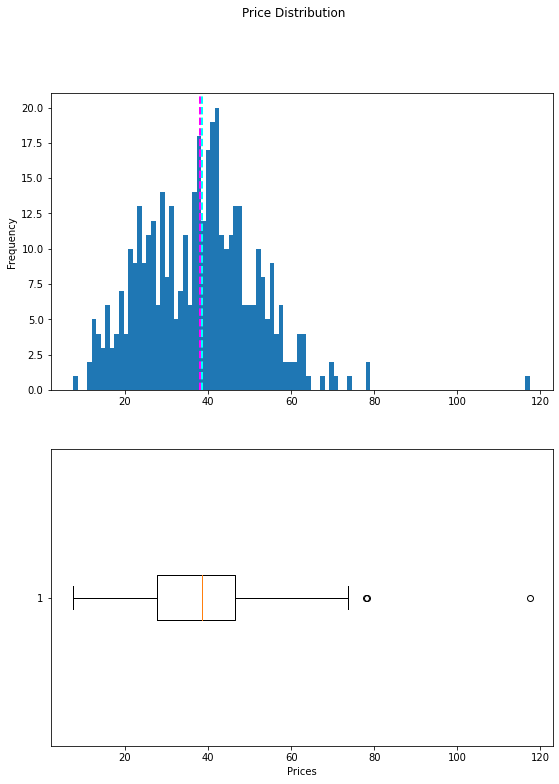

In [10]:
# Get the label column
label = data['price_per_unit']

# Will create a histogram and box plot to examine the distribution of the prices
# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2,1, figsize = (9,12))

# Plot the histogram
ax[0].hist(label,bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for mean and median
ax[0].axvline(label.mean(), color='magenta',linestyle='dashed',linewidth=2)
ax[0].axvline(label.median(),color='cyan',linestyle='dashed',linewidth=2)

# Plot the boxplot
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Prices')

# Add a title
fig.suptitle('Price Distribution')

fig.show()

The housing prices appear to be represented by a normal distribution. Most of the prices are between 10 - 70, with a few outliers. 

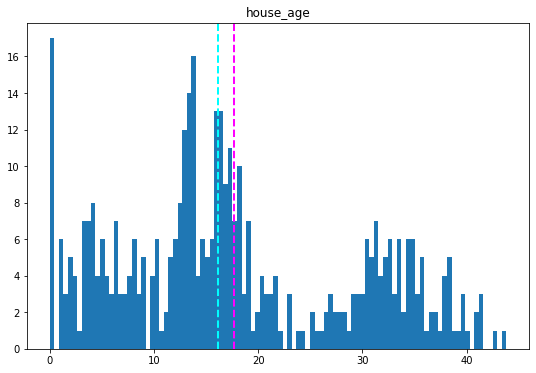

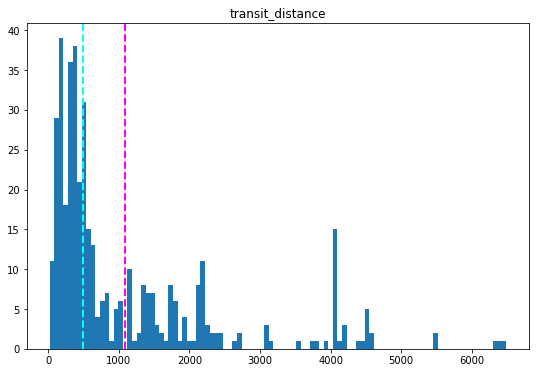

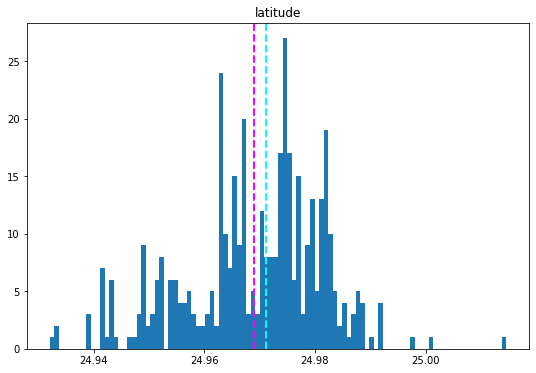

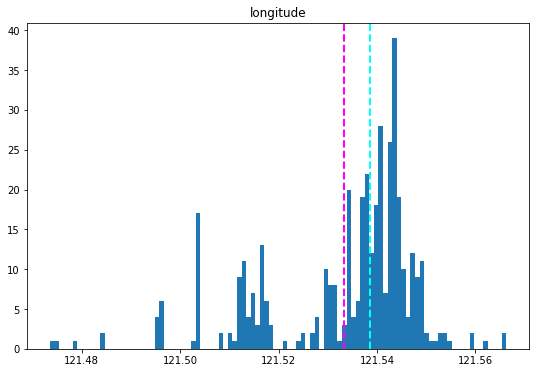

In [11]:
# Plot a histogram for each numeric feature to observe details
for col in numeric_features:  
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = data[col]
  ax.hist(feature,bins=100)
  ax.axvline(feature.mean(),color='magenta',linestyle='dashed',linewidth=2)
  ax.axvline(feature.median(),color='cyan',linestyle='dashed',linewidth=2)
  ax.set_title(col)
plt.show()

In order to get an idea of the distribution of the other numerical features, I plotted individual histograms. Transit distance was interestingly skewed to the left. It appears that most people rely on public transporation in Taiwan. Will be interesting to see how this potentially affects the housing prices.

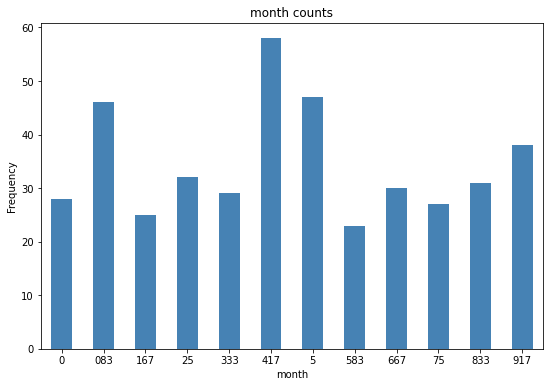

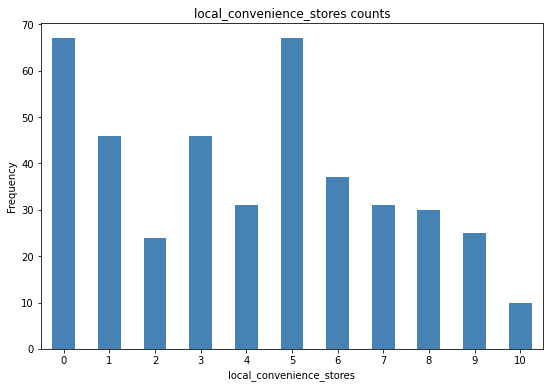

In [12]:
# plot a bar plot for each categorical feature count
for col in categorical_features:
  counts = data[col].value_counts().sort_index()
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  counts.plot.bar(ax=ax, color='steelblue')
  ax.set_title(col + ' counts')
  ax.set_xlabel(col)
  plt.xticks(rotation = 0)
  ax.set_ylabel('Frequency')
plt.show()

Most homes are sold in the beginning and middle of the years.

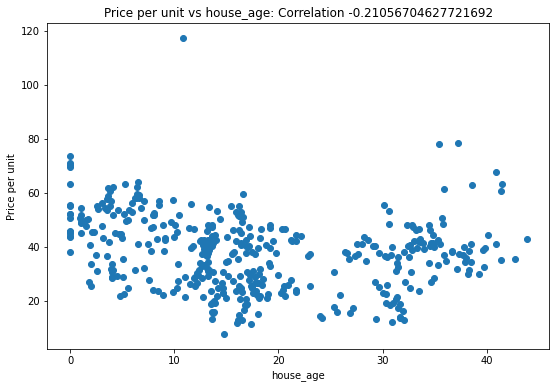

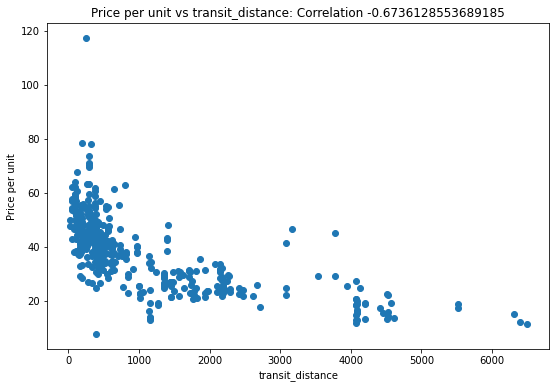

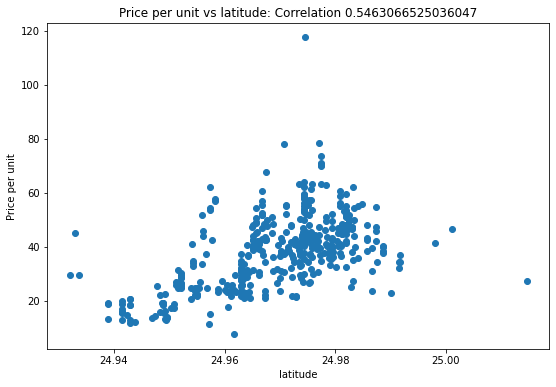

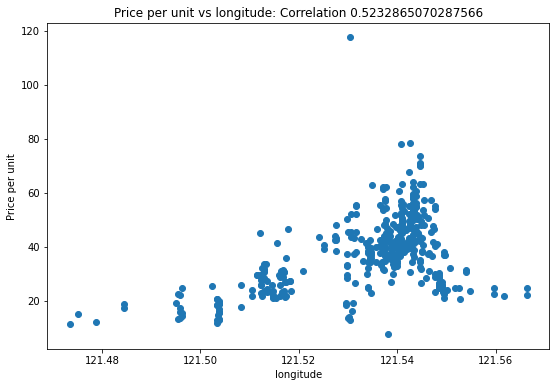

In [13]:
# Look for relationships between features and labels via scatter plots
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = data[col]
  label = data['price_per_unit']
  correlation = feature.corr(label)
  plt.scatter(x=feature,y=label)
  plt.xlabel(col)
  plt.ylabel('Price per unit')
  ax.set_title('Price per unit vs ' + col + ': Correlation ' + str(correlation))
plt.show()

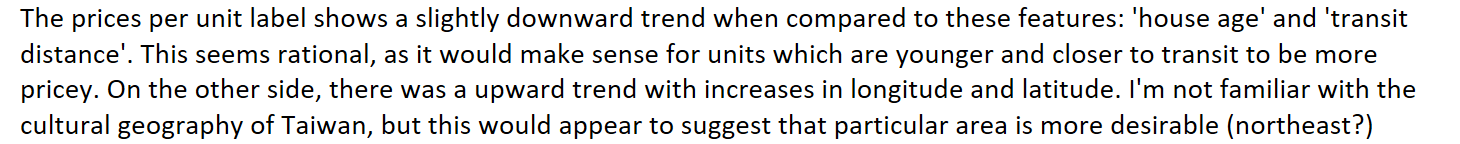

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


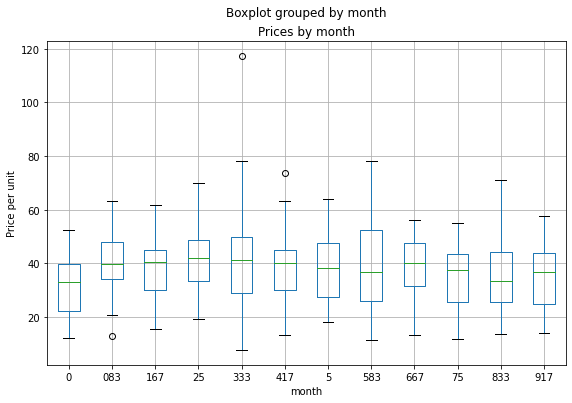

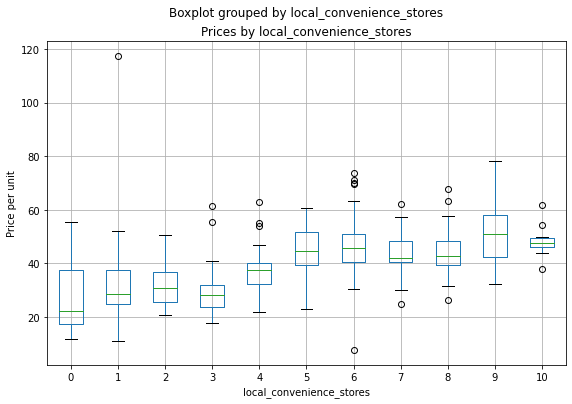

In [14]:
# Compare categorical features to label via box plots
for col in categorical_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  data.boxplot(column = 'price_per_unit',by = col,ax = ax)
  ax.set_title('Prices by ' + col)
  ax.set_ylabel('Price per unit')
plt.show()


There is a solid amount of variation in the prices when it comes to comparing them against the number of local convenience stores. The variation compared to the months is low. I will proceed with training the model without the use of that feature. 

# Train a Regression Model

The time has come to begin training a regresion model. This exercise will be broken down into these phases:

1. Train a vanilla regression model (no feature scaling, parameter optimizations, etc.) to see how the model reacts to the data initially and get a base line of performance.
2. Optimize parameters and train data on several models to observe performance across them.

## Train a vanilla regression model

In [26]:
# Separate the features and labels
X, y  = data[['house_age','transit_distance','local_convenience_stores','latitude','longitude']].values,data['price_per_unit'].values
print('Features: ',X[:10],'\nLabels: ',y[:10],sep='\n')

Features: 
[[3.2000000e+01 8.4878820e+01 1.0000000e+01 2.4982980e+01 1.2154024e+02]
 [1.9500000e+01 3.0659470e+02 9.0000000e+00 2.4980340e+01 1.2153951e+02]
 [1.3300000e+01 5.6198450e+02 5.0000000e+00 2.4987460e+01 1.2154391e+02]
 [1.3300000e+01 5.6198450e+02 5.0000000e+00 2.4987460e+01 1.2154391e+02]
 [5.0000000e+00 3.9056840e+02 5.0000000e+00 2.4979370e+01 1.2154245e+02]
 [7.1000000e+00 2.1750300e+03 3.0000000e+00 2.4963050e+01 1.2151254e+02]
 [3.4500000e+01 6.2347310e+02 7.0000000e+00 2.4979330e+01 1.2153642e+02]
 [2.0300000e+01 2.8760250e+02 6.0000000e+00 2.4980420e+01 1.2154228e+02]
 [3.1700000e+01 5.5120380e+03 1.0000000e+00 2.4950950e+01 1.2148458e+02]
 [1.7900000e+01 1.7831800e+03 3.0000000e+00 2.4967310e+01 1.2151486e+02]]

Labels: 
[37.9 42.2 47.3 54.8 43.1 32.1 40.3 46.7 18.8 22.1]


Separate the data into a set of features (X) and a set of labels (y)

In [27]:
# Split data 70%-30% into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

print('Train Set: {} rows\nTest Set: {} rows'.format(X_train.shape[0],X_test.shape[0]))

Train Set: 289 rows
Test Set: 125 rows


Now we have the following four datasets:

- **X_train**: The feature values we'll use to train the model
- **y_train**: The corresponding labels we'll use to train the model
- **X_test**: The feature values we'll use to validate the model
- **y_test**: The corresponding labels we'll use to validate the model

In [28]:
# Train the fit the model to a Linear Regression
model = LinearRegression().fit(X_train,y_train)
print(model)

LinearRegression()


The model has been trained. Now it is time to evaluate it. 

First I will run predictions for the test values through the model.

After that, I will do a visual plot, followed by statistical analysis via MSE, RMSE, and R2 score metrics.

In [29]:
predictions = model.predict(X_test)

In [37]:
print('First 10 labels - Predicted vs. Actual')
print('Predicted labels: ',np.round(predictions[:10],decimals=1))
print('Actual labels:    ',y_test[:10])

First 10 labels - Predicted vs. Actual
Predicted labels:  [14.1  8.  25.  48.6 30.7 36.9 38.4 40.9 46.6 40.8]
Actual labels:     [19.2 11.2 24.7 46.1 31.3 31.1 30.5 42.2 51.  39.1]


Comparing the first two values of the predictions and ground truths, one can observe the variance in values

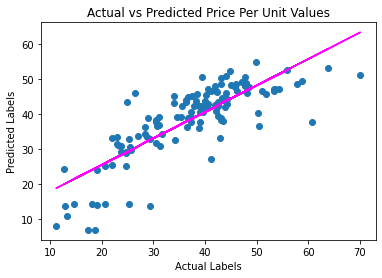

In [47]:
plt.scatter(y_test,predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Actual vs Predicted Price Per Unit Values')
#overlay a regression line
z = np.polyfit(y_test,predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

Visual scatter plot which shows actual vs. prediction labels, with a fitted regression line overlaid on top.

There's a definite diagonal trend, and the intersections of the predicted and actual values are generally following the path of the trend line; but there's a fair amount of difference between the ideal function represented by the line and the results. This variance represents the *residuals* of the model - in other words, the difference between the label predicted when the model applies the coefficients it learned during training to the validation data, and the actual value of the validation label. These residuals when evaluated from the validation data indicate the expected level of *error* when the model is used with new data for which the label is unknown.

In [49]:
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predictions)

print('Statistical Metrics:')
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R2 (aka coefficient of determination): ',r2)

Statistical Metrics:
MSE:  49.17005825812526
RMSE:  7.012136497396871
R2 (aka coefficient of determination):  0.6285584938117281


The vanilla Regression model scored:

- **Mean Square Error (MSE)**: 49.17
- **Root Mean Square Error (RMSE)**: 7.012
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>**): 0.629

For a baseline model, this does not appear to be too bad. Let's see how better we can do with other models and further optimizations

# Train stronger regression models

The first modification I will be doing will be preprocessing the data. I will scale all of the numeric features, and encode the categorical ones. Once this has been completed, I'll run it through the vanilla regression model again to see how the metrics change.

In [58]:
# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,3,4]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [2]
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
                    ('num',numeric_transformer,numeric_features),
                    ('cat',categorical_transformer,categorical_features)])

In [63]:
# Create preprocessing and training pipeline (Linear Regression Model)
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor',LinearRegression())])

# fit the pipeline to train model on training set
model = pipeline.fit(X_train,(y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2])])),
                ('regressor', LinearRegression())])


In [64]:
# Get the predictions
predictions = model.predict(X_test)

In [65]:
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predictions)

print('Statistical Metrics:')
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R2 (aka coefficient of determination): ',r2)

Statistical Metrics:
MSE:  46.72229308708164
RMSE:  6.835370735159991
R2 (aka coefficient of determination):  0.6470494538418069


The vanilla Regression model with preprocessed data scored:

**Mean Square Error (MSE)**: 46.722

**Root Mean Square Error (RMSE)**: 6.835

**Coefficient of Determination (usually known as R-squared or R2)**: 0.647

Let's try the Lasso Linear Regression model next

In [59]:
# Alter the pipeline to use the Lasso model
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor',Lasso())])

# fit the pipeline to train model on training set
model = pipeline.fit(X_train,(y_train))
print(model)

# Get the predictions
predictions = model.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predictions)

print('Statistical Metrics:')
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R2 (aka coefficient of determination): ',r2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2])])),
                ('regressor', Lasso())])
Statistical Metrics:
MSE:  52.92863270662868
RMSE:  7.275206712295444
R2 (aka coefficient of determination):  0.6001653902903965


The Lasso model fared worse.

**Mean Square Error (MSE)**: 52.929

**Root Mean Square Error (RMSE)**: 7.275

**Coefficient of Determination (usually known as R-squared or R2)**: 0.6

Let's try a Random Forest Regressor model next

In [61]:
# Alter the pipeline to use the Random Forest model
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor',RandomForestRegressor())])

# fit the pipeline to train model on training set
model = pipeline.fit(X_train,(y_train))
print(model)

# Get the predictions
predictions = model.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predictions)

print('Statistical Metrics:')
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R2 (aka coefficient of determination): ',r2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2])])),
                ('regressor', RandomForestRegressor())])
Statistical Metrics:
MSE:  33.68994550488339
RMSE:  5.804304050003187
R2 (aka coefficient of determination):  0.7454986928011866


The Random Forest model improved greatly upon the Linear Regression Model.

**Mean Square Error (MSE)**: 33.69

**Root Mean Square Error (RMSE)**: 5.804

**Coefficient of Determination (usually known as R-squared or R2)**: 0.745

Let's try a Gradient Boosting model for our last model

In [62]:
# Alter the pipeline to use the Gradient Boosting model
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor',GradientBoostingRegressor())])

# fit the pipeline to train model on training set
model = pipeline.fit(X_train,(y_train))
print(model)

# Get the predictions
predictions = model.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predictions)

print('Statistical Metrics:')
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R2 (aka coefficient of determination): ',r2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2])])),
                ('regressor', GradientBoostingRegressor())])
Statistical Metrics:
MSE:  32.30742277907672
RMSE:  5.68396189106478
R2 (aka coefficient of determination):  0.7559425755583987


The Gradient Boosting Model fared the best

**Mean Square Error (MSE)**: 32.307

**Root Mean Square Error (RMSE)**: 5.684

**Coefficient of Determination (usually known as R-squared or R2)**: 0.756

Let's make a new prediction

In [69]:
X_new = np.array([[9.2,202.34882,6,24.98443,121.54223]]).astype('float64')
print('New sample: {}'.format(list(X_new[0])))

New sample: [9.2, 202.34882, 6.0, 24.98443, 121.54223]


In [71]:
result = model.predict(X_new)
print('Prediction: {}'.format(result[0]))

Prediction: 53.4312616073027
